# Setpoints

Setpoints are functions of time that establish target values for key control variables. This notebook describes typical nomenclature used in describing setpoint functions, and shows how to creatd setpoint functions in Python.

## Setpoint profiles

Example descriptions from commercial vendors:

* [West Control Solutions: Understanding Setpoint Ramping and Ramp/Soak Temperature Control](https://www.west-cs.com/news/understanding-setpoint-ramping-and-rampsoak-temperature-control/)
* [Eurotherm: Ramp and Soak Applications](https://www.eurotherm.com/us/temperature-control-applications-us/ramp-and-soak-applications/)
* [Allen-Bradley: Introduction to the Allen Bradley Ramp/Soak Controller](https://control.com/technical-articles/Introduction-to-the-Allen-Bradley-Ramp-Soak-Controller-System/)
* [Wikipedia: Thermal Profiling](https://en.wikipedia.org/wiki/Thermal_profiling)

Common descriptions for setpoint functions include so-called **step** changes, and **ramp** and **soak** periods.

* A **step** change is an discontinuous change in setpoint value occuring as specified point in time. An example is specifying a setpoint change from 45 deg C to 65 deg C at a specified point in time.
* A **soak** (or **dwell**) is a specified period of time over which the setpoint is held a constant, specified value.
* A **ramp** is a specified period of time over which the setpoint changes at a constant rate from a specified starting value to a specified final value.
* The **ramp rate** is the rate of change in a setpoint ramp. These may have positive or negative values.

Text(210, 55, 'Soak/Dwell')

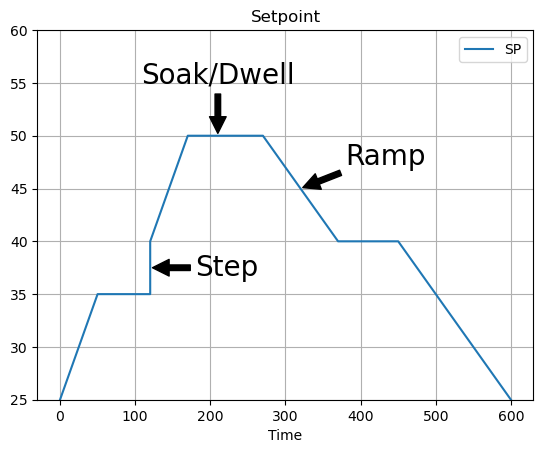

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# specify a setpoint profile
profile = [
    (0, 25),
    (50, 35),
    (120, 35),
    (120, 40),
    (170, 50),
    (170, 50),
    (270, 50),
    (370, 40),
    (450, 40),
    (600, 25),
]

sp_profile = pd.DataFrame(profile, columns=["Time", "SP"])
ax = sp_profile.plot(x="Time", grid=True, ylim=(25, 60), title="Setpoint")
ax.annotate("Step", xy=(120, 37.5), xytext=(180, 37.5), fontsize=20, 
            va="center", arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate("Ramp", xy=(320, 45), xytext=(380, 48), fontsize=20, 
            va="center", arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate("Soak/Dwell", xy=(210, 50), xytext=(210, 55), fontsize=20, 
            ha="center", arrowprops=dict(facecolor='black', shrink=0.05))

<hr>

**Study Question:** Classify all of the segments in the sample setpoint profile.

**Study Question:** What is the ramp rate of the first ramp in the example above.

**Study Question:** Modify the data in the above example to remove the step. Replace it with a single raamp from the initial condition to the soak period that begins at t=170 at a temperature of 170C.

<hr>

## Creating setpoint functions

For feedback control we would like functions that return the value of a setpoint for any point in time. Functions are in the form $SP_1(t)$ and $SP_2(t)$, for example, are straightfoward to use inside in control applications. 

In the section we show how to write a function that accepts points defining a piecewise linear setpoint profile, then produce a function to compute the setpoint for any point in time.

### Specifying piecewise linear setpoint profiles

Describiing the setpoint as a series of a step/ramp/soak periods naturally leads a piecewise linear function. The start and end of each line segment are spceified by (time, value) pairs. Ordering these points into a list provides a straightforward specification of the setpoint, 

Here we show the points for a typical setpoint.

   Time  SP
0     0  25
1    50  35
2   120  35
3   120  40
4   170  50
5   170  50
6   270  50
7   370  40
8   450  40
9   600  25


<AxesSubplot: xlabel='Time'>

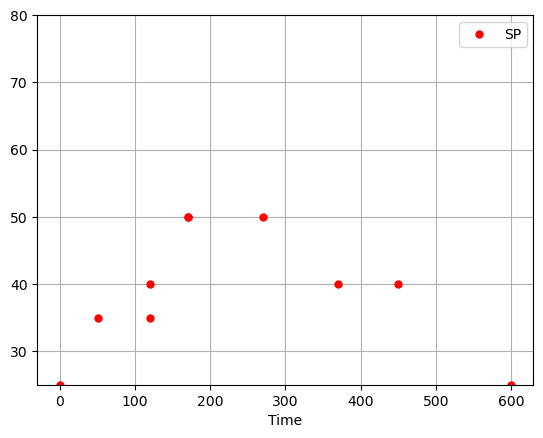

In [2]:
import numpy as np
import matplotlib.pyplot as plt

sp_profile = pd.DataFrame([(0, 25), (50, 35), (120, 35), (120, 40), (170, 50), 
                        (170, 50), (270, 50), (370, 40), (450, 40), (600, 25)],
                       columns=["Time", "SP"])

print(sp_profile)
sp_profile.plot(x="Time", y="SP", style={"SP": "r."}, ms=10, ylim=(25, 80), grid=True)

### Interpolation

Interpolation is a method to fill in points between known values of a function. Here we will use linear interpolation to create a continuous setpoint function given "breakpoint".

The Python standard libraries include 

In [3]:
t_interp = profile["Time"]
sp_interp = profile["SP"]

np.interp(500, t_interp, sp_interp)

TypeError: list indices must be integers or slices, not str

In [4]:
def sp(t):
    t_interp = sp_profile["Time"]
    y_interp = sp_profile["SP"]
    return np.interp(t, t_interp, y_interp)

sp(500)

35.0

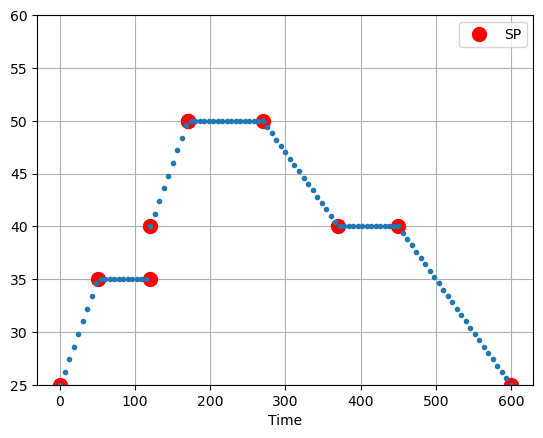

In [5]:
t = np.linspace(0, 600, 101)

ax = sp_profile.plot(x="Time", y="SP", style={"SP": "r."}, ms=20, ylim=(25, 60), grid=True)
ax.plot(t, sp(t), '.')

### A functon to create functions

Python functions are frequently written to accept data, perform calculations, and return values. What may be less familiar is that functions can also return function. This is just what we neeed - a function that accepts a series of (time, value) pairs describing a setpoint profile, then returns a function that can be used to find values of the setpoint at any point in time.

In [6]:
def create_setpoint_function(profile):
    
    profile = np.array(profile)
    t_interp = profile[:, 0]
    y_interp = profile[:, 1]
    
    # define a function to interpolate time and values
    def setpoint_function(t):
        return np.interp(t, t_interp, y_interp)
    
    # return that function
    return setpoint_function

In [7]:
sp1 = create_setpoint_function(sp_profile)

In [10]:
sp1(200)

50.0

In [15]:
sp_profile.loc[5:6,"SP"] = [95, 95]
sp2 = create_setpoint_function(sp_profile)

In [17]:
sp1(170), sp2(170)

(50.0, 95.0)

## Example of a setpoint function

The following example creates a setpoint function that produces setpoints corresponding the profile described in the introduction to this notebook.

In [47]:
sp = create_setpoint_function(sp_profile)

# print select values
t = 100
print(f"at time = {t:3d} setpoint = {sp(t)}")

at time = 100 setpoint = 35.0


We can use the setpoint function to create plots.

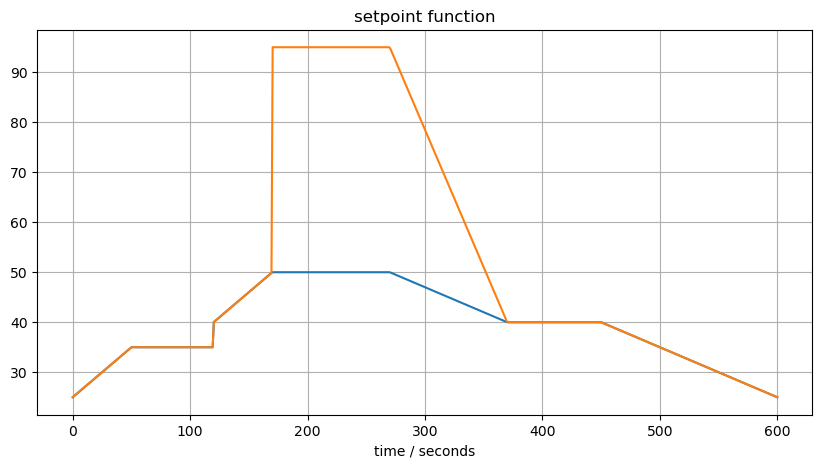

In [20]:
import matplotlib.pyplot as plt

# compute setpoint values
t = np.linspace(0, 600, 600)
y = sp2(t)

# create a plot
fix, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(t, sp1(t), t, sp2(t))
ax.set_xlabel("time / seconds")
ax.set_title("setpoint function")
ax.grid(True)

### Creating multiple setpoint functions 

The next cell demonstrates the use of `create_setpoint_function` to create multiple independent setpoint functions.

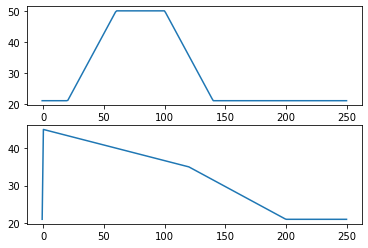

In [50]:
T_amb = 21.0

sp_1 = create_setpoint_function([[0, T_amb], [20, T_amb], [60, 50], [100, 50], [140, T_amb]])
sp_2 = create_setpoint_function([[0, T_amb], [0, 45], [120, 35], [200, T_amb]])

# create plot axes
fig, ax = plt.subplots(2, 1)

# plot setpoint functions
t = np.linspace(-1, 250, 250)
ax[0].plot(t, sp_1(t))
ax[1].plot(t, sp_2(t))